In [ ]:
# https://www.mdpi.com/2076-3417/12/19/10077

In [ ]:
import geopandas as gpd
import rasterio
import pandas as pd
from rasterio.sample import sample_gen
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,classification_report,ConfusionMatrixDisplay,\
                            precision_score,recall_score,f1_score,roc_auc_score, roc_curve

# import matplotlib as plt
import matplotlib.pyplot as plt
import rasterio
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import joblib
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings("ignore") 
warnings.filterwarnings("ignore", category=UserWarning)

### Load sample points and sar data


In [ ]:
# Load SAR GeoTIFF
sar_image_path = "output/sar_image/eaton_sar_indices.tif"

# Load the CSV data
# training_data_path = 'sample_1_training_data.csv'
# training_data_path="sample_1_training_data_texture.csv"
training_data_path="output/sample/training_data_eaton_indices.csv"

training_data=pd.read_csv(training_data_path)
# feature_column_names=["gam_vh_post","gam_vv_post","gam_vh_pre","gam_vv_pre"]
# feature_column_names=["gam_vh_post","gam_vv_post","gam_vh_pre","gam_vv_pre","RBD_VV", "RBD_VH", "RBR_VV", "RBR_VH", "ΔRVI"]
# feature_column_names=["RBD_VV", "RBD_VH", "RBR_VV", "RBR_VH", "ΔRVI",'t1','t2','t3','t4','t5','t6','t7','t8','t9','t10','t11','t12','t13','t14','t15','t16','t17','t18','t19','t20']

feature_column_names=["dTRAD","dNBR","RBD_VV", "RBD_VH", "RBR_VV", "dod_RBR_VV","RBR_VH","dod_RBR_VH","ΔRVI",'Δvv_vh_ratio',"ΔRDFI","RCBI"] #,"ΔRVI",'Δvv_vh_ratio',"ΔRDFI","dTRAD"

# feature_column_names=["RBD_VV", "RBD_VH", "RBR_VV", "RBR_VH", "ΔRVI","Δvv_vh_ratio","ΔRDFI"] #
# feature_column_names=['t1','t2','t3','t4','t5','t6','t7','t8','t9','t10','t11','t12','t13','t14','t15','t16','t17','t18','t19','t20']
# feature_column_names=["gamm_vh_pre","gamm_vv_pre","gamm_vh_post","gamm_vv_post","RBD_VV", "RBD_VH", "RBR_VV", "RBR_VH", "ΔRVI"]
# feature_column_names=["gamm_vh_pre","gamm_vv_pre","gamm_vh_post","gamm_vv_post","RBD_VV", "RBD_VH", "RBR_VV", "RBR_VH", "ΔRVI",'t1','t2','t3','t4','t5','t6','t7','t8','t9','t10','t11','t12','t13','t14','t15','t16','t17','t18','t19','t20']

class_column_name='class'
extended_file_name="_TRAD_1_rcbi_2"


In [ ]:
dataset = rasterio.open(sar_image_path)
# Get the number of bands
num_bands = dataset.count
print(f"Number of bands: {num_bands}")

# To get the names of the bands (if available)
# for i in range(1, num_bands + 1):
#     band_name = dataset.tags(i)  # Retrieve tags for the band
#     print(f"Band {i} name: {band_name}")

Number of bands: 12


In [ ]:
# Separate features (SAR bands) and labels (e.g., class column)
X = training_data[feature_column_names]  # Features (SAR band values)
Y = training_data[class_column_name]  # Labels (add 'Class' column in your CSV if available)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)


In [ ]:
#To visualize data in X_train
# pd.DataFrame(X_train)

In [ ]:
def predict(model, image_path,model_name ):
    dataset = rasterio.open(image_path)
    print(dataset.count)
    # # Load the SAR GeoTIFF
    # image_path = "../SAR_Data_processing/11_export/palisades_indices_subset.tif"
    # dataset = rasterio.open(image_path)

    # Read the image bands into an array (assuming it's a multi-band raster)
    sar_bands = np.stack([dataset.read(i+1) for i in range(dataset.count)], axis=-1)

    # Reshape the SAR data to a 2D array (num_pixels, num_bands)
    height, width, num_bands = sar_bands.shape
    pixels = sar_bands.reshape(-1, num_bands)  # Each row is a pixel
    print(num_bands,"num_bands")

    # Preprocess (scale) the pixel values if needed (based on training data preprocessing)
    # scaler = StandardScaler()
    # pixels_scaled = scaler.fit_transform(pixels)  # Apply scaling to the pixels

    # Predict for each pixel
    predictions = model.predict(pixels)

    from scipy.ndimage import uniform_filter
    # Assuming predictions are a 2D array (for an image or spatial data)
    predictions = uniform_filter(predictions, size=7)  # size is the window size

    # predictions = model.predict(scaler.transform(pixels))


    # Reshape predictions to match the image dimensions
    predicted_image = predictions.reshape(height, width)

    # Save the predicted classes to a new file
    output_path = f"output/prediction/eaton_{model_name}_{extended_file_name}.tif"
    meta = dataset.meta
    meta.update(dtype=rasterio.uint8, count=1)  # Assuming class labels are integers, uint8 works for this

    with rasterio.open(output_path, 'w', **meta) as dest:
        dest.write(predicted_image.astype(rasterio.uint8), 1)  # Write to the first band

    print(f"Predictions saved to {output_path}")

    pred_dataset = rasterio.open(output_path)

    # Read the first band of the image (you can adjust for multi-band images)
    pred_band_1 = pred_dataset.read(1)

    # Plot the image
    plt.figure(figsize=(10, 10))
    plt.imshow(pred_band_1, cmap='gray')  # You can adjust the colormap if needed
    plt.colorbar()
    plt.title("SAR Burnt Area Prediction Map")
    plt.show()


In [ ]:
#indices_tex
# RF_Model_1=RandomForestClassifier(n_estimators= 150, min_samples_split= 8, max_features= 9, max_depth= 10)

#gamma_indices
# RF_Model_1=RandomForestClassifier(n_estimators= 100, min_samples_split= 8, max_features= 20, max_depth= 8)

#gamma
# RF_Model_0=RandomForestClassifier(n_estimators= 150, min_samples_split= 15, max_features= 20, max_depth= 12)
# RF_Model_1=RandomForestClassifier(n_estimators= 200, min_samples_split= 8, max_features= 20, max_depth= 8)
# {'n_estimators': 150, 'min_samples_split': 20, 'max_features': 4, 'max_depth': 15}
#indices
# RF_Model_0=RandomForestClassifier(n_estimators= 150, min_samples_split= 4, max_features= 20, max_depth= 10)
# RF_Model_1=RandomForestClassifier(n_estimators= 150, min_samples_split= 8, max_features= 7, max_depth= 8)


#eaton indices
# RF_Model_0=RandomForestClassifier(n_estimators= 200,random_state=42)
# max_depth= 8
# {'n_estimators': 100, 'min_samples_split': 40, 'max_features': 3, 'max_depth': 8}
RF_Model_0=RandomForestClassifier(n_estimators= 100, min_samples_split= 40, max_features= 3,max_depth= 8,bootstrap=True)
# RF_Model_1=RandomForestClassifier(n_estimators= 100, min_samples_split= 4, max_features= 8, max_depth= 5)
# RF_Model_0 = RandomForestClassifier(
#     n_estimators=100,               # Number of trees in the forest
#     max_depth=None,                  # Trees can grow deep to capture complex patterns
#     min_samples_split=2,             # Minimum samples required to split an internal node
#     min_samples_leaf=1,              # Minimum samples required to be at a leaf node
#     max_features='sqrt',             # Use square root of the total features for each split
#     bootstrap=True,                  # Use bootstrap sampling (default)
#     n_jobs=-1,                       # Use all available processors
#     random_state=42                  # Ensures reproducibility
# )



***************RandomForest0*********************
Model performance for Training set
- Accuracy: 0.8947538860103627
- F1 Score: 0.8933419722386942
- Precision Score: 0.8526252983293556
- Recall Score: 0.7800218340611353
- Roc Auc Score: 0.8615808986143615
--------------
Model performance for Test set
- Accuracy: 0.8743523316062176
- F1 Score: 0.8716041996385707
- Precision Score: 0.8454106280193237
- Recall Score: 0.7291666666666666
- Roc Auc Score: 0.8345081453634084
----------------------------------------
12
12 num_bands
Predictions saved to output/prediction/eaton_RandomForest0__TRAD_1_rcbi_2.tif


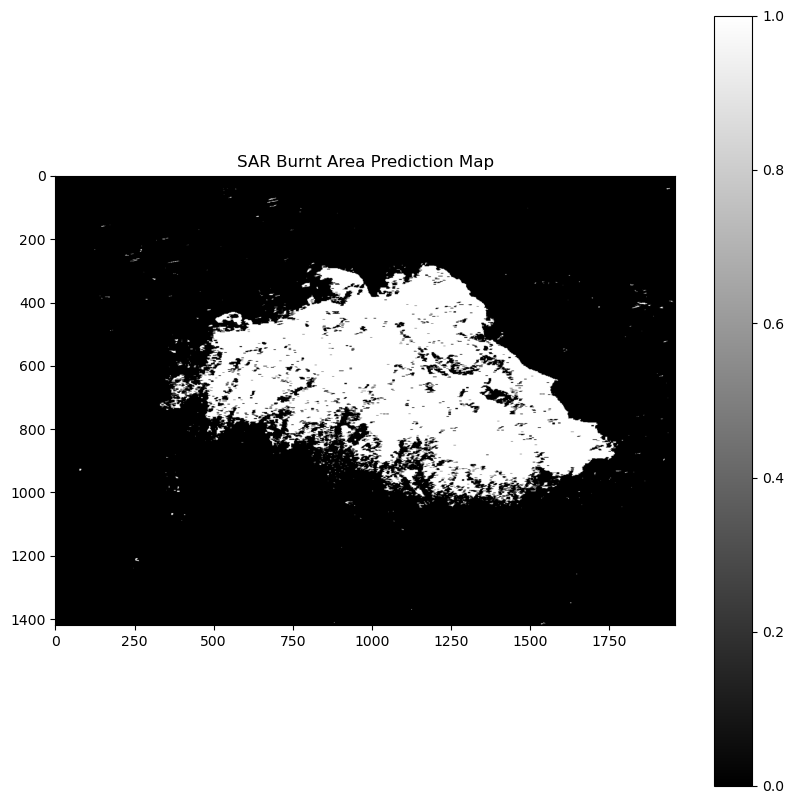

In [ ]:
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()

models={
    "RandomForest0": RF_Model_0,
    # "RandomForest1": RF_Model_1,
    # "RandomForest2": RF_Model_2,
    # "RandomForest3": RF_Model_3,
    # "RandomForest4": RF_Model_4,
    # "RandomForest5": RF_Model_5,

    # "Decision Tree":DecisionTreeClassifier(),
    # "Logistic Regression":LogisticRegression()
    # "XGBoost": XGB_Model
}


for i in range(len(list(models))):
    model_name=list(models.keys())[i]
    print(f"***************{model_name}*********************")
    model=list(models.values())[i]

    # scaler = StandardScaler()
    # pixels_scaled = scaler.fit_transform(pixels)  # Apply scaling to the pixels
    # X_train=scaler.fit_transform(X_train)
    model.fit(X_train, y_train)
    # print("score",model.score(X_test,y_test))

    #Make a prediction
    y_train_pred=model.predict(X_train)
    # y_test_pred=model.predict(scaler.transform(X_test))
    y_test_pred=model.predict(X_test)


    #Training set performance
    model_train_accuracy=accuracy_score(y_train,y_train_pred)
    model_train_f1=f1_score(y_train,y_train_pred,average='weighted')
    model_train_precision=precision_score(y_train,y_train_pred)
    model_train_recall=recall_score(y_train,y_train_pred)
    model_train_roc_auc_score=roc_auc_score(y_train,y_train_pred)

    #Test set performance
    model_test_accuracy=accuracy_score(y_test,y_test_pred)
    model_test_f1=f1_score(y_test,y_test_pred,average='weighted')
    model_test_precision=precision_score(y_test,y_test_pred)
    model_test_recall=recall_score(y_test,y_test_pred)
    model_test_roc_auc_score=roc_auc_score(y_test,y_test_pred)

    # print(model)
    print('Model performance for Training set')
    print(f"- Accuracy: {model_train_accuracy}")
    print(f"- F1 Score: {model_train_f1}")
    print(f"- Precision Score: {model_train_precision}")
    print(f"- Recall Score: {model_train_recall}")
    print(f"- Roc Auc Score: {model_train_roc_auc_score}")

    print("--------------")
    print('Model performance for Test set')
    print(f"- Accuracy: {model_test_accuracy}")
    print(f"- F1 Score: {model_test_f1}")
    print(f"- Precision Score: {model_test_precision}")
    print(f"- Recall Score: {model_test_recall}")
    print(f"- Roc Auc Score: {model_test_roc_auc_score}")
    print("----------------------------------------")

    # predict(model, sar_image_path,model_name,scaler)
    predict(model, sar_image_path,model_name)

    # predict(model, "output/sar_image/palisades_sar_indices.tif",model_name)



# Initialize the Random Forest classifier
# rf_classifier = RandomForestClassifier(n_estimators= 100)

# # Train the model
# rf_classifier.fit(X_train, y_train)

# # Evaluate the model
# accuracy = rf_classifier.score(X_test, y_test)
# print(f"Random Forest Accuracy: {accuracy * 100:.2f}%")

<Axes: >

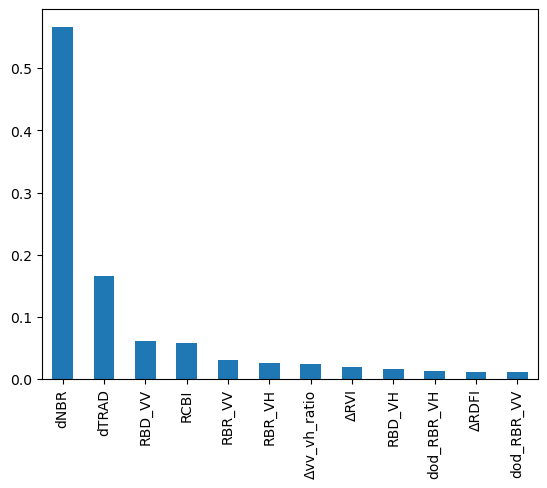

In [ ]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances = pd.Series(RF_Model_0.feature_importances_, index=X_train.columns).sort_values(ascending=False)
# Plot a simple bar chart
feature_importances.plot.bar()

In [ ]:
## plot ROC AUC Curve
plt.figure()
auc_models = [{
    'label': 'Random Forest Classifier',
    'model': RF_Model,
    'auc':0.73
}]

for algo in auc_models:
    model=algo['model']
    model.fit(X_train, y_train)
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
    plt.plot(fpr,tpr,label="Random Forest Classifier ROC (area= 0.71)")

    plt.plot([0,1],[0,1],'r--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('1-Specificity (False Positive Rate)')
    plt.ylabel('Sensitivity (True Positive Rate)')
    plt.title('Receiver operating characteristics')

    plt.legend(loc="lower right")

    plt.savefig("auc.png")
    plt.show()

    # Open the TIFF file using rasterio
    # output_path = "palisades_predictions.tif"  # Replace with your TIFF file path
    


NameError: name 'RF_Model' is not defined

<Figure size 640x480 with 0 Axes>

### Prediction for entire image

In [ ]:
# # import rasterio
# # import matplotlib.pyplot as plt

# # Open the TIFF file using rasterio
# output_path = "palisades_predictions.tif"  # Replace with your TIFF file path
# dataset = rasterio.open(output_path)

# # Read the first band of the image (you can adjust for multi-band images)
# band1 = dataset.read(1)

# # Plot the image
# plt.figure(figsize=(10, 10))
# plt.imshow(band1, cmap='gray')  # You can adjust the colormap if needed
# plt.colorbar()
# plt.title("SAR Image")
# plt.show()

In [ ]:
# Load your trained RF model (update with your actual model path)
# rf_model = joblib.load('path_to_your_trained_rf_model.pkl')


In [ ]:
import numpy as np

# Example thermal values
thermal_values = np.array([-500, 0, 1000, 1500])

# Standardization (Z-score)
mean = np.mean(thermal_values)
std_dev = np.std(thermal_values)
standardized_values = (thermal_values - mean) / std_dev

print("Standardized values:", standardized_values)

In [ ]:
import numpy as np

# Example thermal values
thermal_values = np.array([-500, 0, 1000, 1500])

# Min-Max normalization
thermal_min = np.min(thermal_values)
thermal_max = np.max(thermal_values)
normalized_values = (thermal_values - thermal_min) / (thermal_max - thermal_min)

print("Normalized values:", normalized_values)